# ResNet on CIFAR10

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.utils import convert_tensor
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 4
BATCH_SIZE = 32
EPOCHS = 200

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

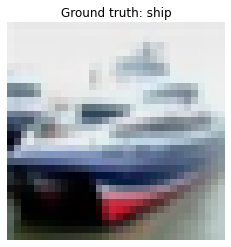

In [8]:
dataset_show_image(test_dset, 1)

## Model

In [9]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.SiLU(inplace=True))
        super().__init__(*layers)

In [10]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False),
            nn.Dropout2d(p_drop)
        )

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, p_drop=0.):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels, p_drop)
        self.act = nn.SiLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [12]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides, p_drop=0.):
        layers = []
        out_channels = in_channels
        for rep, stride in zip(repetitions, strides):
            if stride > 1: layers.append(nn.MaxPool2d(stride))
            for _ in range(rep):
                layers.append(ResidualBlock(in_channels, out_channels, p_drop))
                in_channels = out_channels
            out_channels *= 2
        super().__init__(*layers)

In [13]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, 3, stride=stride))
            in_channels = out_channels
            stride = 1
        super().__init__(*layers)

In [14]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [15]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, res_p_drop=0., head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [32, 32, 64], strides[0]),
            ResidualStack(64, repetitions, strides[1:], res_p_drop),
            Head(64 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [16]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [17]:
model = ResNet(NUM_CLASSES, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], res_p_drop=0., head_p_drop=0.3)

In [18]:
model.apply(init_linear);

In [19]:
model.to(DEVICE);

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 11,200,882


## Loss

In [21]:
def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

In [22]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε=0.1, reduction='mean'):
        super().__init__()
        self.ε = ε
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size(-1)
        log_preds = F.log_softmax(output, dim=-1)
        loss1 = reduce_loss(-log_preds.sum(dim=-1) / c, self.reduction)
        loss2 = F.nll_loss(log_preds, target, reduction=self.reduction)
        loss = (1. - self.ε) * loss2 + self.ε * loss1
        return loss

## CutMix

In [23]:
class CutMix(nn.Module):
    def __init__(self, loss, α=1.0):
        super().__init__()
        self.loss = loss
        self.α = α
        self.rng = np.random.default_rng()
    
    def prepare_batch(self, batch, device, non_blocking):
        x, y = batch
        x = convert_tensor(x, device=device, non_blocking=non_blocking)
        y = convert_tensor(y, device=device, non_blocking=non_blocking)
        
        batch_size = x.size(0)
        self.index = torch.randperm(batch_size).to(device)
        
        self.λ = self.rng.beta(self.α, self.α)
        y1, x1, y2, x2 = self.cut_bounding_box(x.shape[-2:], self.λ)
        x[:, :, y1:y2, x1:x2] = x[self.index, :, y1:y2, x1:x2]
                
        # adjust lambda to exactly match pixel ratio
        area = x.size(2) * x.size(3)
        self.λ = 1. - (x2 - x1) * (y2 - y1) / area
        return x, y
    
    def cut_bounding_box(self, shape, λ):
        cut_size_2 = 0.5 * np.sqrt(1. - λ)
        center_yx = self.rng.random(2)
        
        y1x1 = (np.clip(center_yx - cut_size_2, 0., 1.) * shape).astype(int)
        y2x2 = (np.clip(center_yx + cut_size_2, 0., 1.) * shape).astype(int)
        return np.concatenate((y1x1, y2x2))
        
    def forward(self, pred, target):
        orig_reduction = self.loss.reduction
        self.loss.reduction = 'none'
        batch_loss = self.λ * self.loss(pred, target) + (1. - self.λ) * self.loss(pred, target[self.index])
        self.loss.reduction = orig_reduction
        return reduce_loss(batch_loss, orig_reduction)

## Training

### History

In [24]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Trainer Setup

In [25]:
loss = LabelSmoothingCrossEntropy()

In [26]:
cutmix = CutMix(loss, α=1.0)

In [27]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [28]:
trainer = create_supervised_trainer(model, optimizer, cutmix, device=DEVICE, prepare_batch=cutmix.prepare_batch)

In [29]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [30]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [31]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [32]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [33]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [34]:
history = History()

In [35]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Training

In [36]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/200 - train: loss 1.854; val: loss 1.365 accuracy 0.611
2/200 - train: loss 1.724; val: loss 1.171 accuracy 0.718
3/200 - train: loss 1.599; val: loss 1.038 accuracy 0.771
4/200 - train: loss 1.610; val: loss 1.047 accuracy 0.770
5/200 - train: loss 1.578; val: loss 0.997 accuracy 0.799
6/200 - train: loss 1.535; val: loss 0.962 accuracy 0.810
7/200 - train: loss 1.462; val: loss 0.901 accuracy 0.840
8/200 - train: loss 1.554; val: loss 0.960 accuracy 0.828
9/200 - train: loss 1.496; val: loss 0.883 accuracy 0.853
10/200 - train: loss 1.503; val: loss 0.886 accuracy 0.856
11/200 - train: loss 1.431; val: loss 0.853 accuracy 0.859
12/200 - train: loss 1.455; val: loss 0.847 accuracy 0.866
13/200 - train: loss 1.389; val: loss 0.820 accuracy 0.870
14/200 - train: loss 1.382; val: loss 0.847 accuracy 0.867
15/200 - train: loss 1.436; val: loss 0.827 accuracy 0.880
16/200 - train: loss 1.429; val: loss 0.825 accuracy 0.879
17/200 - train: loss 1.359; val: loss 0.791 accuracy 0.892
18/200

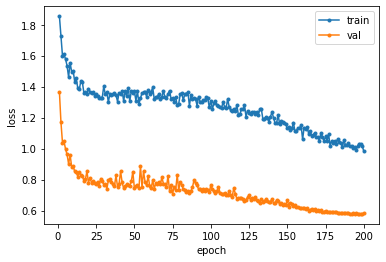

In [37]:
history.plot_train_val('loss')

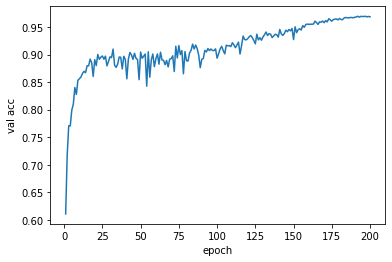

In [38]:
history.plot('val acc')